this `hammer` module is install from rust binding with pyO3

check `rust` folder for more details

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from hammer import dddm
from os.path import abspath, join
root_dir = abspath(join('..', '..'))
import sys
sys.path.append(root_dir)
from utils import style

In [2]:
# plt.style.available

In [3]:
style()

## Math

from Poisson eq.
\begin{aligned}
  \nabla^2\Phi(z, r, \phi) = \frac{\partial^2 \Phi}{\partial z^2}+\frac{1}{r^2}\frac{\partial \Phi}{\partial \phi^2} + \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) = 4\pi G\rho
\end{aligned}

Assume axisymmetric potential, and can be decoupled
\begin{aligned}
  \Phi(z, r, \phi) =  \Phi(z, r) =  \Phi_z(z) + \Phi_r(r)
\end{aligned}

Therefore
\begin{aligned}
  \nabla^2\Phi(z, r, \phi)  = \frac{\partial^2 \Phi_z}{\partial z^2}+ \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) = 4\pi G\rho
\end{aligned}

where (Buch et. al. [2019](https://iopscience.iop.org/article/10.1088/1475-7516/2019/04/026))
\begin{aligned}
  \mathcal{R} &= \frac{1}{(4\pi G)} \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) \\
    &= (3.4\pm 0.6)\times10^{-3} M_\odot /\text{pc}^3
\end{aligned}

and $\rho$ is divided into three parts
* Baryon, $\rho_i$
* Thin Dark Disk, $\rho_\text{DD}$
* Constant Local Halo Dark Matter $\rho_\text{DM}$


Using Bahcall Model for Baryon, for each components
\begin{aligned}
  \rho_i = \rho_{i,0}\exp{\left(-\frac{\Phi(z)}{\sigma_{z,i}}\right)}
\end{aligned}
And total baryons
\begin{aligned}
  \rho_b = \sum_i^N\rho_i
\end{aligned}

For thin DD
\begin{aligned}
  \rho_\text{DD}(z) = \frac{\Sigma_\text{DD}}{4h_\text{DD}}\text{sech}^2\left(\frac{z}{2h_\text{DD}}\right)
\end{aligned}

So,
\begin{aligned}
  \frac{\partial^2 \Phi_z}{\partial z^2} &= 4\pi G\rho_\text{eff} \\
  \frac{1}{4\pi G}\frac{\partial^2 \Phi_z}{\partial z^2} &= \sum_i^N\left[\rho_{i,0}\exp{\left(-\frac{\Phi(z)}{\sigma_{z,i}}\right)}\right] + \frac{\Sigma_\text{DD}}{4h_\text{DD}}\text{sech}^2\left(\frac{z}{2h_\text{DD}}\right) + \rho_\text{DM} - \mathcal{R}
\end{aligned}

All of this math has been baked into `hammer` module. Check out the `rust` folder for more details.

Example

In [4]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
rhob = [
    0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,
    0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015
]
sigmaz = [
    3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 
    18.0, 18.5, 18.5, 20.0, 20.0]
# dark matter density
rhoDM = [0.016]
# dark disk
# sigmaDD = [7]
# log_hDD = [np.log(30)]
rhoDD = [0.01]
log_lambdaDD = [np.log(1)]

# normalisation of vertical density profile
log_nu0 = [0]

# the rotation curve term
R = [3.4E-3]

# the solar offset
zsun = [30]

# the vertical velocity offset
w0 = [-7.]

# the vertical velocity dispersion
sigma1 = 5.
sigma2 = 10.
log_sigmaw = [np.log(sigma1)]
q_sigmaw = [sigma1/sigma2]
# the vertical velocity normalisation
a1 = 0.9
a2 = 0.1
log_a = [np.log(a1)]
q_a = [a2/a1]

theta = np.array([rhob + sigmaz + rhoDM+ rhoDD + log_lambdaDD + log_nu0 + R + zsun + w0 + log_sigmaw + q_sigmaw + log_a + q_a]).flatten()

# integration limits
z_start = 0
z_end = 200
theta.shape

(35,)

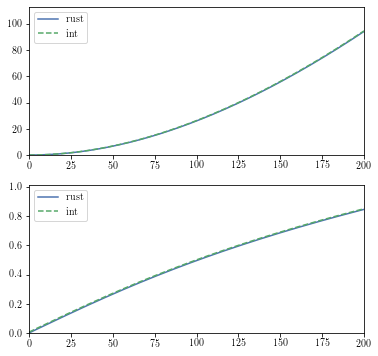

In [5]:
dz = 1
z, phi, Kz = dddm.solve_potential(theta, z_start, z_end, dz)
u = np.array([phi, Kz])
dphi, dKz = dddm.f(z, u, theta)
phi_int = np.cumsum(dphi)*dz
Kz_int = np.cumsum(dKz)*dz
# subplot
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(z, phi, label=r"rust")
ax[0].plot(z, phi_int, label=r"int", ls="--")
# ax[0].set_xlabel(r"$z$ (pc)")
# ax[0].set_ylabel(r"$\phi$ (km/s)$^2$")
ax[0].set_xlim(0, z[-1])
ax[0].set_ylim(0, phi[-1]*1.2)
ax[0].legend()
ax[1].plot(z, Kz, label=r"rust")
ax[1].plot(z, Kz_int, label=r"int", ls="--")
# ax[1].set_xlabel(r"$z$ (pc)")
# ax[1].set_ylabel(r"$K_z$ [pc (km/s)$^2$]")
ax[1].set_xlim(0, z[-1])
ax[1].set_ylim(0, Kz[-1]*1.2)
ax[1].legend()
# plt.tight_layout()
plt.show()

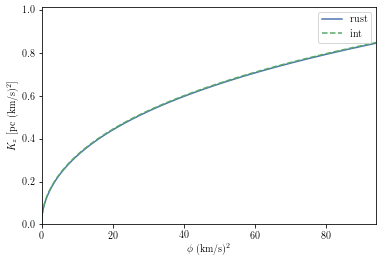

In [6]:
plt.plot(u[0], u[1], label=r"rust")
plt.plot(phi_int, Kz_int, label=r"int", ls="--")
plt.xlabel(r"$\phi$ (km/s)$^2$")
plt.ylabel(r"$K_z$ [pc (km/s)$^2$]")
plt.xlim(0, u[0][-1])
plt.ylim(0, u[1][-1]*1.2)
plt.legend()
plt.show()

Check the difference for different z interval

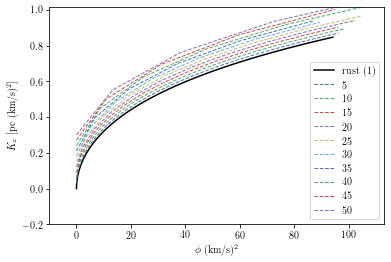

In [7]:
z, phi, Kz = dddm.solve_potential(theta, z_start, z_end, 1)
plt.plot(phi, Kz, label=r"rust (1)", c='k')
for dz in range(5, 51, 5):
    z, phi, Kz = dddm.solve_potential(theta, z_start, z_end, dz)
    u = np.array([phi, Kz])
    dphi, dKz = dddm.f(z, u, theta)
    phi_int = np.cumsum(dphi)*dz
    Kz_int = np.cumsum(dKz)*dz
    plt.plot(phi_int, Kz_int, label=dz, ls="--", lw=1)
plt.xlabel(r"$\phi$ (km/s)$^2$")
plt.ylabel(r"$K_z$ [pc (km/s)$^2$]")
plt.xlim(-10, u[0][-1]*1.2)
plt.ylim(-0.2, u[1][-1]*1.2)
plt.legend()
plt.show()

the interval `z = 1` is the most accurate